# Python for Data Analysis by Wes McKinney

# 2: Introductory Examples

In [193]:
# Set up
%matplotlib inline

from collections import Counter
import json
import matplotlib.pyplot as plt
from pandas import DataFrame, Series
import pandas as pd
import re
import urllib
import zipfile


## 2.1 usa.gov data from bit.ly

"In 2011, URL-shortening service bit.ly partnered wit the US govt website usa.gov to provide a feed of anonymous data gather from users who shorten links ending with _.gov_ or_.mil_. Hourly snapshots are aailable as downloadable text files."

I went to http://www.usa.gov/About/developer-resources/1usagov.shtml. I didn't see hourly snapshots available as downloadable text files, but I did find: 

"You can access the feed at (http://developer.usa.gov/1usagov)"

Clicking on that link gives a live feed of the requests coming in. 

I'm not sure how to best read that feed into a list of dictionaries, so keeping my eye on the prize (data manipulation more than data input streaming - right now) I let the stream run for about 10 minutes, then copied the browser output (JSON), clipped a blank first line, made sure the last entry wasn't clipped, and pasted it into a text file. That yields a 2186 line file, which I'll use for these tests.

Update: using a longer file with entries collected over an hour or two.

In [194]:
#path = 'data/1.usa.gov.snapshot_2016012_10minutes.txt'
# Let's go for more records:
path = 'data/1.usa.gov.snapshot_2016012_2hours.txt'
records = [json.loads(line) for line in open(path, 'r')]
records[0:2]

[{'_id': '6fa2b19f-d0c0-75e4-3f24-e878b47574f4',
  'a': 'Mozilla/5.0 (iPhone; CPU iPhone OS 9_2 like Mac OS X) AppleWebKit/601.1.46 (KHTML, like Gecko) Mobile/13C75 [FBAN/FBIOS;FBAV/46.0.0.54.156;FBBV/18972819;FBDV/iPhone7,2;FBMD/iPhone;FBSN/iPhone OS;FBSV/9.2;FBSS/2; FBCR/AT&T;FBID/phone;FBLC/en_US;FBOP/5]',
  'al': 'en-us',
  'c': 'US',
  'g': '1Y8qQBg',
  'h': '1Y8qQBf',
  'hc': 1449850407,
  'hh': '1.usa.gov',
  'i': '',
  'k': '',
  'l': 'obriennolan',
  'll': [38, -97],
  'nk': 0,
  'r': 'http://m.facebook.com',
  't': 1452617145,
  'u': 'https://str.llnl.gov/november-2015/burton'},
 {'_id': '80496ee4-4a15-8a9c-4c4d-18687d3490ae',
  'a': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36',
  'al': 'en-US,en;q=0.8',
  'c': 'US',
  'cy': 'Chicago',
  'g': '21N65zM',
  'gr': 'IL',
  'h': '1SKB63m',
  'hc': 1452549683,
  'hh': '1.usa.gov',
  'i': '',
  'k': '',
  'l': 'bremeruw',
  'll': [41.8825, -87.6441],
  'mc': 602,
  

Not all entries have timezone fields, such as the first record. But the second does:

In [195]:
records[1]['tz']

'America/Chicago'

### Counting Time Zones in Pure Python

In [196]:
# Extract the list of time zones in the list of records.

# This will result in an error because not all records have a tz field.
timezones = [record['tz'] for record in records ]

KeyError: 'tz'

In [ ]:
timezones = [record['tz'] for record in records if 'tz' in record]
timezones[:10]

In [ ]:
# How many have an empty timezone?
n_empty_timezones = len([tz for tz in timezones if tz == ''])
print(n_empty_timezones)

In [ ]:
# Try 1: dictionary 
def get_counts1(sequence):
    counts = {}
    for x in sequence:
        if x in counts:
            counts[x] += 1
        else:
            counts[x] = 1
    return counts

# Try 2: default dictionary
from collections import defaultdict
def get_counts2(sequence):
    counts = defaultdict(int) # int type default dict defaults to 0
    for x in sequence:
        counts[x] += 1
    return counts
    
def top_counts(counts, n=10):
    value_key_pairs = [(count, tz) for tz, count in counts.items()]
    value_key_pairs.sort()
    return value_key_pairs[-n:]

counts1 = get_counts1(timezones)
counts2 = get_counts2(timezones)
if counts1 != counts2:
    print(counts1)
    print(counts2)
    raise Exception('Expecting same result with two alternatives.')

for entry in top_counts(counts2):
    print(entry)


In [ ]:
# Best python method: Counter class
counts = Counter(timezones)
counts.most_common(10)

### Counting Time Zones with pandas

In [ ]:
frame = DataFrame(records)
frame.info()
frame['tz'][:10]

In [ ]:
tz_counts = frame['tz'].value_counts()
tz_counts[:10]

In [ ]:
print('Number of timezone cells with no entry = {0}'.format(frame['tz'].isnull().sum()))
print('Number of timezone cells with empty entry = {0}'.format(len(frame[frame.tz == ''])))
empties = frame[frame['tz'] == '']
print(len(empties))

In [ ]:
clean_tz = frame['tz'].fillna('Missing')
print('This should be of type = Series: {0}'.format(type(clean_tz)))
# Not needed with this particular dataset, but just in case:
clean_tz[clean_tz == ''] = 'Unknown'
tz_counts = clean_tz.value_counts()
tz_counts[:10]

In [ ]:
barplot = tz_counts[:10].plot(kind='barh', title='Top time zones in the 1.usa.gov sample data')
barplot.grid()
plt.show()

### Breakdown URL requests by browser and by platform (Windows, etc)

In [ ]:
# Browser breakdown
# Handle empty browser fields.
browsers = Series([row.split()[0] for row in frame.a.dropna() if len(row) > 0])
browsers.value_counts()[:10]


Decompose timezones into host operating system (Windows, Mac, Linux, Mobile, ...)

In [ ]:
frame.a[:50]
frame.a[-50:]

In [ ]:
def extract_operating_system(agent_string):
    """OS is the string between the first ( and the first space or semi-colon,
    whichever is first.
    """
    regex = re.compile('^.*\((?P<OS>\w*)[;/\s].*$')
    result = regex.match(agent_string)
    if not result:
        #raise Exception("Could not parse agent string '{0}'".format(agent_string))
        return '(Unknown)'
    return result.group('OS')

test_agent_string_os_pairs = [
    ('Mozilla/5.0 (Linux; Android 4.4.2; SPH-L710 Bu', 'Linux'),
    ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_', 'Macintosh'),
    ('Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi', 'Windows'),
    ('Mozilla/5.0 (iPhone; CPU iPhone OS 9_2 like Ma', 'iPhone'),
    ('Mozilla/5.0 (compatible; MSIE 10.0; Windows NT', 'compatible'),
    ('newspaper/0.0.9.8', '(Unknown)')
]

for (agent_string, expected_os) in test_agent_string_os_pairs:
    actual_os = extract_operating_system(agent_string)
    if actual_os != expected_os:
        raise Exception("Nope. Expected '{0}', got {1}".format(expected_os, actual_os))
print("All good!")

In [ ]:
operating_system = frame.a.apply(extract_operating_system)
type(operating_system)


In [ ]:
operating_system.value_counts()

In [ ]:
len(operating_system[operating_system == ''])

In [ ]:
os_counts = operating_system.value_counts()
drop_list = []
mapto_mapfrom_list = (
    ('(Unknown)', ''),
    ('(Unknown)', 'unknown'),
    ('(Unknown)', 'Unknown'),
    ('Windows', 'compatible'),
    ('Linux', 'X11'),
    ('Linux', 'Ubuntu'),
    ('Linux', 'Debian'),
    ('iOS', 'iPhone'),
    ('iOS', 'iPad'),
    ('iOS', 'iPod'),
)
# Cleanup:
for (addto, addfrom) in mapto_mapfrom_list:
    if addto not in os_counts:
        os_counts[addto] = 0
    os_counts[addto] += os_counts[addfrom]
    drop_list.append(addfrom)

os_counts.drop(drop_list, inplace=True)
print('After:\n{0}'.format(os_counts))

Compute an array of what OS each URL is requested from

In [ ]:
cframe = frame[frame.a.notnull()]
operating_system = frame.a.apply(extract_operating_system)
for newname, oldname in mapto_mapfrom_list:
    operating_system[operating_system == oldname] = newname
    
# Cleanup: Put the minor players into '(Other)'
major_os_categories = (
    'Windows',
    'Linux',
    'Macintosh',
    'iOS',
    '(Unknown)',
    '(Other)',
    'Mobile',
    'Android'
)

#No:operating_system[operating_system not in major_os_categories] = '(Other)'
operating_system = operating_system.apply(lambda x: x if x in major_os_categories else '(Other)')
operating_system.value_counts()

Group the data by its time zone and this list of operating systems:

In [ ]:
by_tz_os = cframe.groupby(['tz', operating_system])
type(by_tz_os)

"The group counts, analogous to _value_counts_ function above, can be computed using size.
This result is then reshaped into a table with _unstack_:"

In [ ]:
#agg_counts = by_tz_os.size().unstack().fillna(0)
sized = by_tz_os.size()
type(sized) # A Series
sized[:10]

In [ ]:
unstacked = sized.unstack().fillna(0)
unstacked.info()

In [ ]:
agg_counts = unstacked
agg_counts.head()

*Select the top overall time zones by constructing an indirect index array from the row counts in __agg_counts__:*

In [ ]:
# Use to sort in ascending order
agg_sums = agg_counts.sum(1)
#type(agg_sums) # Series
agg_sums[:10]


In [ ]:
indexer = agg_sums.argsort()
# type(indexer) # Series
indexer[:10]

*Use __take__ to select the rows in that order, then slice off the last 10 rows:*

In [ ]:
count_subset = agg_counts.take(indexer)[-10:]
count_subset

*Plot as a stacked horizontal bar chart*

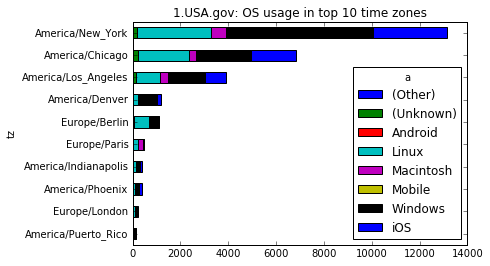

In [198]:
barplot = count_subset.plot(kind='barh', stacked=True, title='1.USA.gov: OS usage in top 10 time zones')
plt.show()

*This plot doesn't make it easy to see the relative percentages in the smaller groups,
but the rows can be normalied to sum to 1,
then plotted again:*

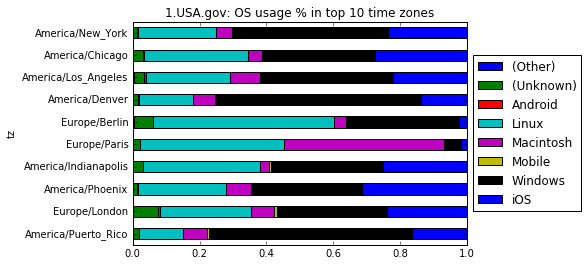

In [197]:
# Put the legend outside the barplot, shrinking the plot to make room on the right
normed_subset = count_subset.div(count_subset.sum(1), axis=0)
barplot = normed_subset.plot(kind='barh', stacked=True,
                  title='1.USA.gov: OS usage % in top 10 time zones').legend(
                    loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 2.2 MovieLens 1M Data Set

Just to make it interesting, I considered using a larger and more recent movie rating dataset from the same organization, such as [MovieLens 10M Data Set](http://grouplens.org/datasets/movielens/10m/). But it turns out that the later datasets removed user demographics such as gender. That's a shame. So using the dataset that Wes used.

In [200]:
movie_lens_1m_dataset_path = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'

names = {
    'users': ('user_id', 'gender', 'age', 'occupation', 'zip'),
    'ratings': ('user_id', 'movie_id', 'rating', 'timestamp'),
    'movies': ('movie_id', 'title', 'genres')
    }

files = {
    'users': 'ml-1m/users.dat',
    'ratings': 'ml-1m/ratings.dat',
    'movies': 'ml-1m/movies.dat',
    }
    
# Python 3 puts urlretrieve in module request. Documentation calls this method 'legacy', but it's usable.
needed_file_set = set(files.values())
try:
    filehandle, _ = urllib.request.urlretrieve(movie_lens_1m_dataset_path)
    zip_file_object = zipfile.ZipFile(filehandle, 'r')
    zip_file_set = set(zip_file_object.namelist())
    zip_file_object.extractall()
    print('Extracted: {0}'.format(zip_file_set))
    if not needed_file_set < zip_file_set:
        raise IOError('Missing needed files "{0}"'.format(needed_file_set - zip_file_set))
finally:
    urllib.request.urlcleanup()

Extracted: {'ml-1m/ratings.dat', 'ml-1m/movies.dat', 'ml-1m/users.dat', 'ml-1m/', 'ml-1m/README'}


In [211]:
dfs = {}
for file_type in files.keys():
    # engine='python' avoids error 'the 'c' engine does not support regex separators',
    # which I believe is due to a two character separator.
    dfs[file_type] = pd.read_table(files[file_type], sep='::', header=None, names=names[file_type], engine='python')
    

In [212]:
dfs['users'][:5]

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [213]:
dfs['ratings'][:5]

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [214]:
dfs['movies'][0:5]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [217]:
data = pd.merge(pd.merge(dfs['ratings'], dfs['movies']), dfs['users'])
data

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067
5,1,1197,3,978302268,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,F,1,10,48067
6,1,1287,5,978302039,Ben-Hur (1959),Action|Adventure|Drama,F,1,10,48067
7,1,2804,5,978300719,"Christmas Story, A (1983)",Comedy|Drama,F,1,10,48067
8,1,594,4,978302268,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,F,1,10,48067
9,1,919,4,978301368,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical,F,1,10,48067


I reversed the order of the merge: ratings+movies first, then that with users, 
with no difference in result other than the order of columns.

Aggregate the ratings of each movie by the gender of the rater.

In [221]:
mean_ratings = data.pivot_table('rating', index='title', columns='gender', aggfunc='mean')
mean_ratings[:5]

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


#### Filter out movies with less than 250 ratings.

In [234]:
ratings_by_title_before_size = data.groupby('title')
ratings_by_title_before_size.describe()


age  movie_id  \
title                                                                    
$1,000,000 Duck (1971)                     count   37.000000        37   
                                           mean    31.162162      2031   
                                           std      9.558340         0   
                                           min     18.000000      2031   
                                           25%     25.000000      2031   
                                           50%     35.000000      2031   
                                           75%     35.000000      2031   
                                           max     50.000000      2031   
'Night Mother (1986)                       count   70.000000        70   
                                           mean    33.271429      3112   
                                           std     11.744776         0   
                                           min      1.000000      3112   
                                           25%     25.000000      3112   
                                           50%     35.000000      3112   
                                           75%     42.500000      3112   
                                           max     56.000000      3112   
'Til There Was You (1997)                  count   52.000000        52   
                                           mean    28.826923       779   
                                           std     11.811794         0   
                                           min      1.000000       779   
                                           25%     25.000000       779   
                                           50%     25.000000       779   
                                           75%     35.000000       779   
                                           max     56.000000       779   
'burbs, The (1989)                         count  303.000000       303   
                                           mean    27.897690      2072   
                                           std     10.561054         0   
                                           min      1.000000      2072   
                                           25%     18.000000      2072   
                                           50%     25.000000      2072   
...                                                      ...       ...   
Zero Effect (1998)                         std     10.844052         0   
                                           min      1.000000      1845   
                                           25%     25.000000      1845   
                                           50%     25.000000      1845   
                                           75%     35.000000      1845   
                                           max     56.000000      1845   
Zero Kelvin (Kj�rlighetens kj�tere) (1995) count    2.000000         2   
                                           mean    35.000000      1364   
                                           std      0.000000         0   
                                           min     35.000000      1364   
                                           25%     35.000000      1364   
                                           50%     35.000000      1364   
                                           75%     35.000000      1364   
                                           max     35.000000      1364   
Zeus and Roxanne (1997)                    count   23.000000        23   
                                           mean    21.000000      1426   
                                           std     13.954471         0   
                                           min      1.000000      1426   
                                           25%      9.500000      1426   
                                           50%     25.000000      1426   
                                           75%     35.000000      1426   
                                           max     45.000000 

In [235]:
ratings_by_title_before_size.head(10)

,age,gender,genres,movie_id,occupation,rating,timestamp,user_id,zip
0,1,F,Drama,1193,10,5,978300760,1,48067
1,1,F,Animation|Children's|Musical,661,10,3,978302109,1,48067
2,1,F,Musical|Romance,914,10,3,978301968,1,48067
3,1,F,Drama,3408,10,4,978300275,1,48067
4,1,F,Animation|Children's|Comedy,2355,10,5,978824291,1,48067
5,1,F,Action|Adventure|Comedy|Romance,1197,10,3,978302268,1,48067
6,1,F,Action|Adventure|Drama,1287,10,5,978302039,1,48067
7,1,F,Comedy|Drama,2804,10,5,978300719,1,48067
8,1,F,Animation|Children's|Musical,594,10,4,978302268,1,48067
9,1,F,Adventure|Children's|Drama|Musical,919,10,4,978301368,1,48067


In [225]:
ratings_by_title = ratings_by_title_before_size.size()
ratings_by_title[:10]

title
$1,000,000 Duck (1971)                37
'Night Mother (1986)                  70
'Til There Was You (1997)             52
'burbs, The (1989)                   303
...And Justice for All (1979)        199
1-900 (1994)                           2
10 Things I Hate About You (1999)    700
101 Dalmatians (1961)                565
101 Dalmatians (1996)                364
12 Angry Men (1957)                  616
dtype: int64

In [236]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [238]:
mean_ratings = mean_ratings.ix[active_titles]
mean_ratings

gender,F,M
title,,
"'burbs, The (1989)",2.793478,2.962085
10 Things I Hate About You (1999),3.646552,3.311966
101 Dalmatians (1961),3.791444,3.500000
101 Dalmatians (1996),3.240000,2.911215
12 Angry Men (1957),4.184397,4.328421
"13th Warrior, The (1999)",3.112000,3.168000
2 Days in the Valley (1996),3.488889,3.244813
"20,000 Leagues Under the Sea (1954)",3.670103,3.709205
2001: A Space Odyssey (1968),3.825581,4.129738


In [242]:
#top_female_ratings = mean_ratings.sort_index(by='F', ascending=False)
# sort_index deprecated. Use sort_values instead.
top_female_ratings = mean_ratings.sort_values(by='F', ascending=False)
top_female_ratings[:10]

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415
"Shawshank Redemption, The (1994)",4.539075,4.560625
"Grand Day Out, A (1992)",4.537879,4.293255
To Kill a Mockingbird (1962),4.536667,4.372611
Creature Comforts (1990),4.513889,4.272277


### Measuring rating disagreement

Find the movies that are most divisive between male and female.
Add a diff column to hold difference in means between male and female.

In [243]:
mean_ratings['diff'] = mean_ratings['M'] - mean_ratings['F']
sorted_by_diff = mean_ratings.sort_values(by='diff')
sorted_by_diff[:15]

gender,F,M,diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777
Anastasia (1997),3.800000,3.281609,-0.518391
"Rocky Horror Picture Show, The (1975)",3.673016,3.160131,-0.512885
"Color Purple, The (1985)",4.158192,3.659341,-0.498851
"Age of Innocence, The (1993)",3.827068,3.339506,-0.487561


In [244]:
# Top 15 movies preferred by men not women
sorted_by_diff[::-1][:15]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787
Evil Dead II (Dead By Dawn) (1987),3.297297,3.909283,0.611985
"Hidden, The (1987)",3.137931,3.745098,0.607167
Rocky III (1982),2.361702,2.943503,0.581801
Caddyshack (1980),3.396135,3.969737,0.573602


Most disagreement among viewers

In [256]:
# Standard deviation of rating grouped by title
rating_std_by_title = data.groupby('title')['rating'].std()
# Filter out movies with few ratings
rating_std_by_title = rating_std_by_title.ix[active_titles]
# Order Series by value in descending order
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## 2.3 US Baby Names 1880-2010

### Analyzing Naming Trends

## 2.4 Conclusions